In [1]:
import numpy as np
#from plotly.offline import download_plotlyjs, init_notebook_mode,plot,iplot
#init_notebook_mode(connected=True)
#import plotly.graph_objs as go
import matplotlib.pyplot as plt
%matplotlib inline

model_name = "DRAM_classify_blobs_2"
data_directory = "data/" + model_name + "/"

num_runs = 10
iter_list = [0, 250, 1000, 4000, 16000, 32000, 64000, 125000, 250000, 500000, 1000000, 2000000]
glimpse_list = [0, 3, 9]
max_blobs = 15
min_blobs = 1

num_iters = len(iter_list)
num_glimpses = len(glimpse_list)
output_size = max_blobs - min_blobs + 1
chist = np.load(data_directory + 'choice_hist.npy')
cm = np.load(data_directory + 'choice_msdcv.npy')

cmus = cm[:,:,:,:,0] # mean
csds = cm[:,:,:,:,1] # sd
ccvs = cm[:,:,:,:,2] # cv

In [2]:
# take the averages across the 10 runs
chist_mu = np.mean(chist,axis=0)
cmus_mu = np.mean(cmus,axis=0)
cmus_min = np.min(cmus,axis=0)
cmus_max = np.max(cmus,axis=0)
csds_mu = np.mean(csds,axis=0)
csds_min = np.min(csds,axis=0)
csds_max = np.max(csds,axis=0)
ccvs_mu = np.mean(ccvs,axis=0)
ccvs_min = np.min(ccvs,axis=0)
ccvs_max = np.max(ccvs,axis=0)

In [3]:
def plot_hists(matrix,i_ind):
    fig, ax = plt.subplots(9,num_glimpses,sharex=True, sharey=True,figsize=(16,8))
    x = range(min_blobs, max_blobs + 1)
    fig.tight_layout()
    plt.xticks(range(min_blobs, max_blobs + 1))
    for c in range(num_glimpses):
        tstr = 'I = ' + str(iter_list[i_ind]) + ', G = ' + str(glimpse_list[c])
        ax[0,c].set_title(tstr)
        for i in range(9):
            ax[i,c].plot(x,matrix[c,i,:max_blobs])
    plt.show()

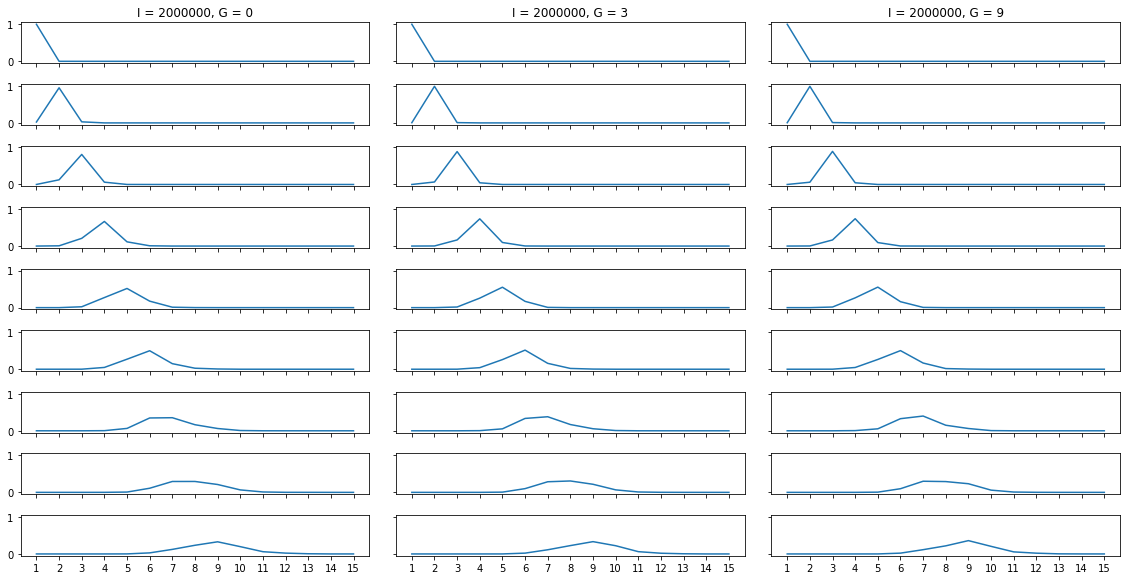

In [4]:
iter_idx = num_iters - 1
plot_hists(chist_mu[iter_idx,:,:,:],iter_idx)

In [5]:
def plot_stats(title,smu,smin,smax):
    fig, ax = plt.subplots(num_iters,len(glimpse_list),sharex=True, sharey=True,figsize=(8,20))
    fig.tight_layout()
    plt.xticks(range(1,10))
    x = range(1,10)
    for i in range(num_iters):
        for g in range(num_glimpses):
            tstr = 'I = ' + str(iter_list[i]) + ', G = ' + str(glimpse_list[g])
            ax[i,g].set_title(tstr)
            ax[i,g].plot(x,smu[i,g,:9],'k-')
            ax[i,g].fill_between(x,smin[i,g,:9],smax[i,g,:9], facecolor='orange')
    fig.suptitle(title, fontsize=16)
    fig.subplots_adjust(top=0.95)
    plt.show()
    return plt

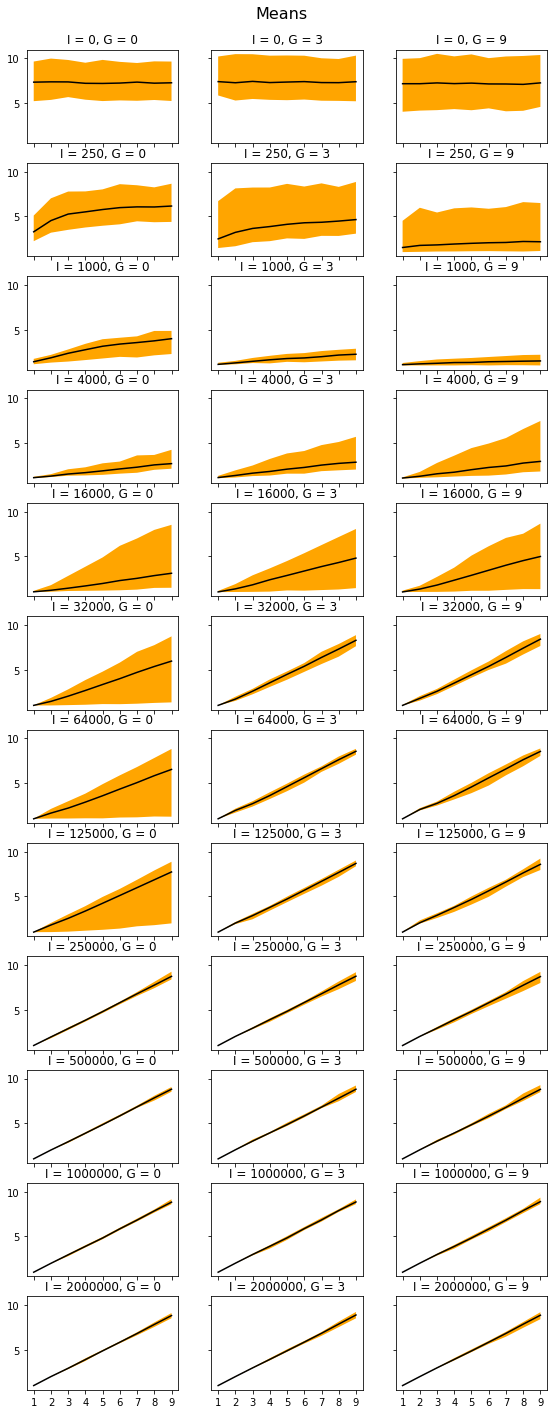

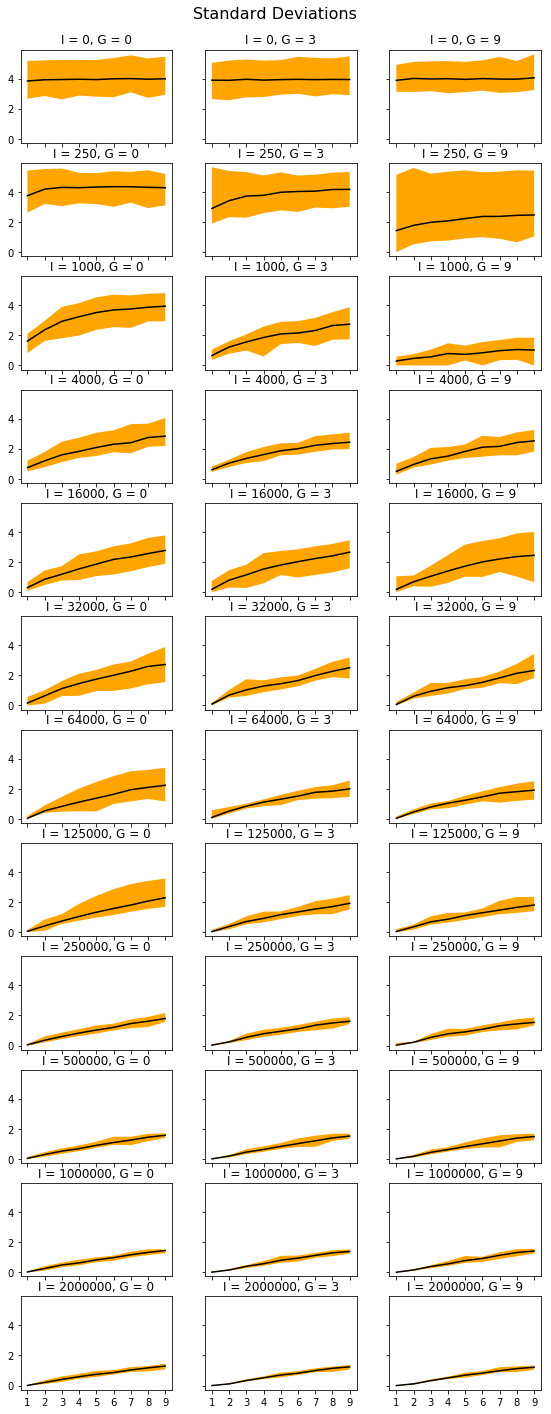

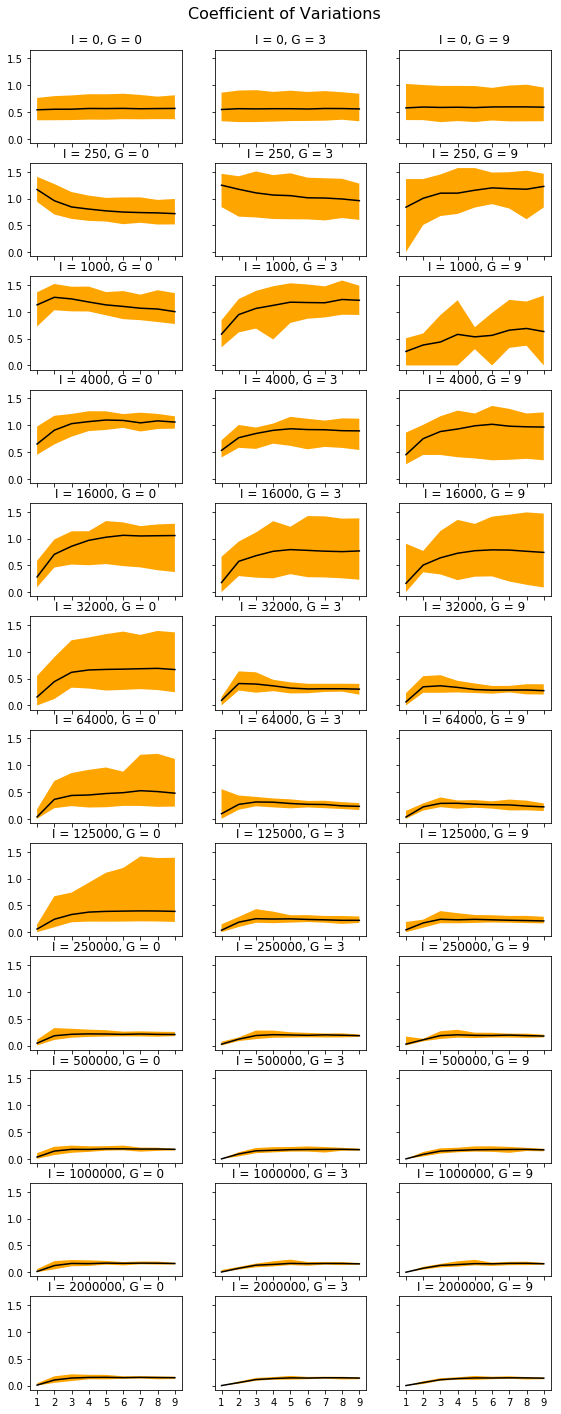

In [6]:
plot_stats("Means",cmus_mu,cmus_min,cmus_max)
plot_stats("Standard Deviations",csds_mu,csds_min,csds_max)
plot_stats("Coefficient of Variations",ccvs_mu,ccvs_min,ccvs_max)

## Run Linear Regression

In [7]:
import scipy.stats as st

def get_linreg(cvals):
    """Get lines of best fit."""
    
    slopes = np.zeros([num_runs, num_iters, num_glimpses])
    intercepts = np.zeros([num_runs, num_iters, num_glimpses])
    r_vals = np.zeros([num_runs, num_iters, num_glimpses])

    for run in range(num_runs):
        for i, it in enumerate(iter_list):
            for g, glimpse in enumerate(glimpse_list):
                for n in range(1,10):
                    slopes[run,i,g], intercepts[run,i,g], r_vals[run,i,g], \
                        _, _ = st.linregress(cvals[run,i,g,:9], range(1,10))
    
    return slopes, intercepts, r_vals

In [19]:
cmus_slopes, cmus_intercepts, cmus_rvals = get_linreg(cmus)
csds_slopes, csds_intercepts, csds_rvals = get_linreg(csds)
ccvs_slopes, ccvs_intercepts, ccvs_rvals = get_linreg(ccvs)

[[[ -4.19088359 -13.87549558  -5.09728225]
  [  7.59953413   6.92176742   4.91519454]
  [  4.31037681   4.63830869   7.50420235]
  [  4.33426272   4.30634416   4.39745246]
  [  2.63559343   2.53736399   2.5010324 ]
  [  3.29260353   3.66983152   3.63975257]
  [  3.96618117   4.13593947   4.19201564]
  [  4.02313957   3.80585681   4.11809647]
  [  5.34930446   5.70178098   5.812157  ]
  [  5.56116029   5.96839019   6.15223041]
  [  5.58790768   5.77268258   5.62780502]
  [  6.06669131   6.09941285   6.23104025]]

 [[  3.81531369 -17.40755802  10.51662511]
  [  3.95211968   4.78705654   5.62792464]
  [  3.62389907   5.30043187  14.99853053]
  [  5.06840568   4.87522697   4.94343348]
  [  5.42545554   4.60632637   4.87594114]
  [  2.47624633   2.7992899    2.7515057 ]
  [  3.85356513   4.17982853   4.07658824]
  [  3.91204049   4.15288311   5.01521253]
  [  4.96036775   5.21288894   5.62931589]
  [  5.7275845    5.91950766   6.12431552]
  [  5.78780655   5.9608819    6.0893523 ]
  [  6.72

In [9]:
import math

def get_CI(vals):
    """Get the 95% confidence intervals."""
        
    for i, it in enumerate(iter_list):
        print("iteration " + str(it) + ": ")
        for g, glimpse in enumerate(glimpse_list):
            print("glimpse " + str(glimpse) + ": ")
            mean = np.mean(vals[:,i,g])
            sd = np.std(vals[:,i,g])
            hw = 1.96*sd/math.sqrt(9)
            print("(" + str(mean - hw) + ", " + str(mean + hw) + ")")

# Confidence Intervals

## Mean Choice

### Slope

In [10]:
get_CI(cmus_slopes)

iteration 0: 
glimpse 0: 
(-8.00104348468, -0.601570377493)
glimpse 3: 
(-5.08068932347, 4.70782455805)
glimpse 9: 
(-6.53775118079, 2.04910077632)
iteration 250: 
glimpse 0: 
(2.17857319387, 2.90272683229)
glimpse 3: 
(3.08119024409, 4.24343527206)
glimpse 9: 
(6.75683923492, 25.8148581054)
iteration 1000: 
glimpse 0: 
(2.42828845312, 4.20885022513)
glimpse 3: 
(5.45059256827, 9.82742122438)
glimpse 9: 
(15.0220443173, 56.9735706065)
iteration 4000: 
glimpse 0: 
(4.35017783111, 6.43709749665)
glimpse 3: 
(4.11283272824, 6.15484552417)
glimpse 9: 
(4.06876647681, 6.95403040344)
iteration 16000: 
glimpse 0: 
(3.93374418755, 9.92837271794)
glimpse 3: 
(1.28175750019, 7.68718989276)
glimpse 9: 
(1.18979397156, 9.0572503679)
iteration 32000: 
glimpse 0: 
(0.331158958542, 8.5934720246)
glimpse 3: 
(1.04057703748, 1.12404251105)
glimpse 9: 
(1.0209690116, 1.11929072901)
iteration 64000: 
glimpse 0: 
(-0.0570849610295, 10.5350221977)
glimpse 3: 
(1.03268254303, 1.06348599848)
glimpse 9: 
(1.0

### Intercept

In [11]:
get_CI(cmus_intercepts)

iteration 0: 
glimpse 0: 
(10.2751110654, 66.6046535152)
glimpse 3: 
(-35.5878812037, 42.7384507442)
glimpse 9: 
(-10.5244346123, 49.8529141593)
iteration 250: 
glimpse 0: 
(-9.43971100614, -6.93706640964)
glimpse 3: 
(-11.5633092468, -5.43442660518)
glimpse 9: 
(-26.887834233, -9.397295898)
iteration 1000: 
glimpse 0: 
(-4.87738010109, -3.15831391029)
glimpse 3: 
(-9.91744656557, -5.19765831184)
glimpse 9: 
(-57.0524263708, -15.7644960594)
iteration 4000: 
glimpse 0: 
(-5.92744004391, -3.71716523635)
glimpse 3: 
(-5.70736017844, -3.75837772497)
glimpse 9: 
(-6.15957614573, -3.26284670372)
iteration 16000: 
glimpse 0: 
(-8.57588494299, -2.56977813967)
glimpse 3: 
(-6.12173064245, -0.0896870048913)
glimpse 9: 
(-7.44958898587, 0.193817674985)
iteration 32000: 
glimpse 0: 
(-6.97891631273, 0.981118434323)
glimpse 3: 
(-0.0159603201197, 0.23519735094)
glimpse 9: 
(-0.00244490446988, 0.285140396767)
iteration 64000: 
glimpse 0: 
(-8.92381451116, 1.24573551635)
glimpse 3: 
(-0.0198147055529

### R-Values

In [12]:
get_CI(cmus_rvals)

iteration 0: 
glimpse 0: 
(-0.470473624403, 0.0124594419571)
glimpse 3: 
(-0.314535588361, 0.263514011258)
glimpse 9: 
(-0.430177556296, 0.226183855536)
iteration 250: 
glimpse 0: 
(0.825212023657, 0.880678904131)
glimpse 3: 
(0.860171105161, 0.948908871189)
glimpse 9: 
(0.782651196923, 0.937910625344)
iteration 1000: 
glimpse 0: 
(0.965398698349, 0.982377869259)
glimpse 3: 
(0.959641208565, 0.984022120959)
glimpse 9: 
(0.720417008877, 0.98547668475)
iteration 4000: 
glimpse 0: 
(0.977000396853, 0.988065350954)
glimpse 3: 
(0.980574939189, 0.99111894537)
glimpse 9: 
(0.979706934552, 0.992080272442)
iteration 16000: 
glimpse 0: 
(0.967668158157, 0.992978498722)
glimpse 3: 
(0.979838571067, 0.997115769366)
glimpse 9: 
(0.980827935791, 0.993539390139)
iteration 32000: 
glimpse 0: 
(0.979854421159, 0.996862018022)
glimpse 3: 
(0.996590843254, 0.998822825615)
glimpse 9: 
(0.99526137668, 0.99846389716)
iteration 64000: 
glimpse 0: 
(0.956337854219, 1.00306848419)
glimpse 3: 
(0.997594057316,

## Standard Deviation of Choice

### Slope

In [13]:
get_CI(csds_slopes)

iteration 0: 
glimpse 0: 
(0.446924810791, 15.3628090409)
glimpse 3: 
(-4.32852487538, 11.841559441)
glimpse 9: 
(-3.12582060224, 10.4324060137)
iteration 250: 
glimpse 0: 
(-5.66881478072, 4.21726374264)
glimpse 3: 
(0.931059134115, 6.64681457179)
glimpse 9: 
(4.83521373918, 5.86137394303)
iteration 1000: 
glimpse 0: 
(2.80473311752, 3.73322291644)
glimpse 3: 
(3.26321074623, 4.28306763095)
glimpse 9: 
(5.59344704317, 13.2391019656)
iteration 4000: 
glimpse 0: 
(3.31561599642, 4.3084639126)
glimpse 3: 
(3.70977857009, 4.89015780051)
glimpse 9: 
(3.36079323396, 4.59060908684)
iteration 16000: 
glimpse 0: 
(2.74491473263, 4.10443862939)
glimpse 3: 
(2.80235501789, 3.73341314823)
glimpse 9: 
(2.42234409299, 3.78096418756)
iteration 32000: 
glimpse 0: 
(2.64462288225, 3.65925925948)
glimpse 3: 
(3.13423253851, 3.70262715371)
glimpse 9: 
(3.19062886322, 3.9173905431)
iteration 64000: 
glimpse 0: 
(3.1443717176, 4.30466520932)
glimpse 3: 
(3.79164739657, 4.40529659175)
glimpse 9: 
(3.746150

### Intercept

In [14]:
get_CI(csds_intercepts)

iteration 0: 
glimpse 0: 
(-52.719798542, 5.12089875032)
glimpse 3: 
(-39.9650322193, 24.9996928281)
glimpse 9: 
(-39.2686796073, 16.6012495287)
iteration 250: 
glimpse 0: 
(-13.430950753, 31.1526088657)
glimpse 3: 
(-20.3411624055, 5.69387910037)
glimpse 9: 
(-11.6341316715, -1.40318309346)
iteration 1000: 
glimpse 0: 
(-6.23002849133, -4.16273086137)
glimpse 3: 
(-2.40788324074, -1.51689784157)
glimpse 9: 
(-2.83692188137, 0.415342267226)
iteration 4000: 
glimpse 0: 
(-2.82100492429, -1.66935282445)
glimpse 3: 
(-2.94379749471, -1.57620917049)
glimpse 9: 
(-2.1995198865, -0.891098472952)
iteration 16000: 
glimpse 0: 
(-0.929325666323, -0.123128782123)
glimpse 3: 
(-0.621729703381, 0.396954473003)
glimpse 9: 
(-0.311743062703, 1.18037676672)
iteration 32000: 
glimpse 0: 
(-0.185694755601, 0.399632839629)
glimpse 3: 
(-0.115413526501, 0.371545529427)
glimpse 9: 
(0.0228920761916, 0.654654581535)
iteration 64000: 
glimpse 0: 
(0.221421370402, 0.677678288679)
glimpse 3: 
(-0.402963664487

### R-Values

In [15]:
get_CI(csds_rvals)

iteration 0: 
glimpse 0: 
(0.0651959293603, 0.540656288578)
glimpse 3: 
(-0.210956238243, 0.494458659138)
glimpse 9: 
(-0.126593583575, 0.450098007944)
iteration 250: 
glimpse 0: 
(-0.182738909311, 0.584684440119)
glimpse 3: 
(0.435773019279, 0.976640593911)
glimpse 9: 
(0.626581544078, 0.906696299015)
iteration 1000: 
glimpse 0: 
(0.88164017173, 0.931442232527)
glimpse 3: 
(0.90035580999, 0.956122187156)
glimpse 9: 
(0.7019906166, 0.924393043871)
iteration 4000: 
glimpse 0: 
(0.944186635976, 0.971408573238)
glimpse 3: 
(0.943594189306, 0.969986910476)
glimpse 9: 
(0.941430373846, 0.971793197011)
iteration 16000: 
glimpse 0: 
(0.95594723086, 0.977134364209)
glimpse 3: 
(0.891022967052, 0.99141897526)
glimpse 9: 
(0.768654237851, 1.0228543215)
iteration 32000: 
glimpse 0: 
(0.966897279411, 0.983703211925)
glimpse 3: 
(0.943986175592, 0.984907705593)
glimpse 9: 
(0.908679393264, 0.989365348125)
iteration 64000: 
glimpse 0: 
(0.942769316922, 0.987665063718)
glimpse 3: 
(0.940724974077, 0.

## Coefficient of Variation of Choice

### Slope

In [16]:
get_CI(ccvs_slopes)

iteration 0: 
glimpse 0: 
(42.5874122143, 141.633747096)
glimpse 3: 
(-49.467642495, 83.8289641672)
glimpse 9: 
(-39.2526193841, 61.9169040726)
iteration 250: 
glimpse 0: 
(-17.4850017578, -14.3073529168)
glimpse 3: 
(-27.461050757, -20.4431291091)
glimpse 9: 
(-16.3227367143, 16.0831036467)
iteration 1000: 
glimpse 0: 
(-22.8059017296, -10.1440532654)
glimpse 3: 
(7.96365023452, 11.7743874404)
glimpse 9: 
(10.8596380088, 20.3070133371)
iteration 4000: 
glimpse 0: 
(5.52754056574, 13.8727727764)
glimpse 3: 
(10.5934045394, 14.1654624403)
glimpse 9: 
(0.303877666383, 12.5553145842)
iteration 16000: 
glimpse 0: 
(3.54264285379, 7.67679184258)
glimpse 3: 
(-1.73686510361, 5.48299142336)
glimpse 9: 
(-4.0269739337, 5.79985381796)
iteration 32000: 
glimpse 0: 
(2.24122485194, 9.61397053096)
glimpse 3: 
(1.01958280796, 8.97139994265)
glimpse 9: 
(-1.06702598986, 12.5404184334)
iteration 64000: 
glimpse 0: 
(7.65461863486, 15.6097870361)
glimpse 3: 
(-0.178125315261, 16.9930796171)
glimpse 9:

### Intercept

In [17]:
get_CI(ccvs_intercepts)

iteration 0: 
glimpse 0: 
(-56.4807170473, -22.911164393)
glimpse 3: 
(-32.684249655, 34.9821410161)
glimpse 9: 
(-29.9051441091, 28.370381642)
iteration 250: 
glimpse 0: 
(15.9371454806, 20.596648765)
glimpse 3: 
(25.1724762379, 36.5104653979)
glimpse 9: 
(-14.9867665141, 26.1602347203)
iteration 1000: 
glimpse 0: 
(15.968976332, 29.8750325322)
glimpse 3: 
(-7.3956887355, -3.48065530625)
glimpse 9: 
(-5.76191938474, -0.58833118667)
iteration 4000: 
glimpse 0: 
(-8.86944671753, -0.175328286387)
glimpse 3: 
(-7.39994230142, -3.55755789806)
glimpse 9: 
(-6.21428549689, 1.65000914529)
iteration 16000: 
glimpse 0: 
(-2.28827438733, 1.69465317496)
glimpse 3: 
(0.423010201727, 5.95981718596)
glimpse 9: 
(0.172714933474, 7.75157659368)
iteration 32000: 
glimpse 0: 
(-0.214069280953, 3.35461504503)
glimpse 3: 
(2.42491505614, 4.6647111879)
glimpse 9: 
(1.69898606339, 5.24527046664)
iteration 64000: 
glimpse 0: 
(0.622897493165, 1.93026459827)
glimpse 3: 
(0.987880009219, 5.82988156132)
glimpse

### R-Values

In [18]:
get_CI(ccvs_rvals)

iteration 0: 
glimpse 0: 
(0.312254309034, 0.607317214636)
glimpse 3: 
(-0.194550041915, 0.461347794684)
glimpse 9: 
(-0.219874602431, 0.471900494589)
iteration 250: 
glimpse 0: 
(-0.864609911195, -0.811693321026)
glimpse 3: 
(-0.921414819919, -0.763759354861)
glimpse 9: 
(-0.0282895507238, 0.832413165214)
iteration 1000: 
glimpse 0: 
(-0.976002410498, -0.321999719434)
glimpse 3: 
(0.672881650749, 0.813546658151)
glimpse 9: 
(0.666102626096, 0.864735895991)
iteration 4000: 
glimpse 0: 
(0.390142565669, 0.779801367428)
glimpse 3: 
(0.4743893998, 0.725159574873)
glimpse 9: 
(0.359401002846, 0.806942748308)
iteration 16000: 
glimpse 0: 
(0.425128445906, 0.875637633789)
glimpse 3: 
(-0.0127693454634, 0.667271528467)
glimpse 9: 
(-0.0383651969345, 0.686640144525)
iteration 32000: 
glimpse 0: 
(0.216072440548, 0.680075672323)
glimpse 3: 
(0.0161570582115, 0.302205412922)
glimpse 9: 
(0.027772315581, 0.391282495926)
iteration 64000: 
glimpse 0: 
(0.425857829318, 0.6991084435)
glimpse 3: 
(-0.